In [1]:
import os
import hashlib
from pathlib import Path
import argparse

import torch
from torch.utils.data import DataLoader
from lightning.pytorch.callbacks import BasePredictionWriter
import pandas as pd
import lightning.pytorch as pl
from FUCCIDataset import FUCCIDatasetInMemory, ReferenceChannelDatasetInMemory, FUCCIChannelDatasetInMemory
from LightningModules import AutoEncoder, FUCCIDataModule

import numpy as np
import multiscale_phate
import scprep
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import wandb
import seaborn as sns

In [3]:
# Do I ever use a cache again?????

if args.data / "index.csv" not in args.data.iterdir():
    if args.channels == "reference":
        dataset = ReferenceChannelDatasetInMemory(args.data, imsize=256)
    elif args.channels == "fucci":
        dataset = FUCCIChannelDatasetInMemory(args.data, imsize=256)
    else:
        dataset = FUCCIDatasetInMemory(args.data, imsize=256)
    cache = []
    for i in range(len(dataset)):
        exp_dir, cell_index = dataset.image_exp_index(i)
        cache.append({
            "index": i,
            "hash": img_hash(dataset[i]),
            "directory": str(exp_dir[1]),
            "cell_index": cell_index
        })
    cache = pd.DataFrame(cache)
    cache.to_csv(args.data / "index.csv")

else:
    cache = pd.read_csv(args.data / "index.csv")

In [4]:
model = AutoEncoder.load_from_checkpoint(args.model)

In [5]:
dm = FUCCIDataModule(args.data, args.channels, imsize=256, batch_size=16, num_workers=8, in_memory=True)

In [6]:
predict_dm = dm

In [7]:
class CustomWriter(BasePredictionWriter):

    def __init__(self, output_dir, write_interval):
        super().__init__(write_interval)
        self.output_dir = output_dir

    def write_on_epoch_end(self, trainer, pl_module, predictions, batch_indices):
        # this will create N (num processes) files in `output_dir` each containing
        # the predictions of it's respective rank
        torch.save(predictions, os.path.join(self.output_dir, f"predictions_{trainer.global_rank}.pt"))

        # optionally, you can also save `batch_indices` to get the information about the data index
        # from your prediction data
        torch.save(batch_indices, os.path.join(self.output_dir, f"batch_indices_{trainer.global_rank}.pt"))

In [8]:
pred_writer = CustomWriter(output_dir=args.data, write_interval="epoch")
trainer = pl.Trainer(accelerator="gpu", devices=devices, callbacks=[pred_writer])
model.set_predict_mode("embedding")
trainer.predict(model, datamodule=predict_dm, return_predictions=False)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/8


Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/8
Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/8
Initializing distributed: GLOBAL_RANK: 3, MEMBER: 4/8
Initializing distributed: GLOBAL_RANK: 4, MEMBER: 5/8
Initializing distributed: GLOBAL_RANK: 6, MEMBER: 7/8
Initializing distributed: GLOBAL_RANK: 5, MEMBER: 6/8
Initializing distributed: GLOBAL_RANK: 7, MEMBER: 8/8
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 8 processes
----------------------------------------------------------------------------------------------------

LOCAL_RANK: 4 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
LOCAL_RANK: 7 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
LOCAL_RANK: 6 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
LOCAL_RANK: 5 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5

Predicting: 0it [00:00, ?it/s]

In [9]:
predictions = []
batch_indices = []
for i in range(devices):
    predictions.append(torch.load(args.data / f"predictions_{i}.pt"))
    batch_indices.append(torch.load(args.data / f"batch_indices_{i}.pt")[0])

def flatten_one(l):
    return [item for sublist in l for item in sublist]

print(len(predictions), len(predictions[0]))
print(len(batch_indices))

predictions = flatten_one(predictions)
batch_indices = flatten_one(batch_indices)
print(len(predictions), len(predictions[0]))
print(len(batch_indices))

mu_predictions = [prediction[0] for prediction in predictions]
var_predictions = [prediction[1] for prediction in predictions]
print(len(mu_predictions), len(var_predictions))

mu_predictions = flatten_one(mu_predictions)
var_predictions = flatten_one(var_predictions)
batch_indices = flatten_one(batch_indices)
print(len(mu_predictions), len(var_predictions))
print(len(batch_indices))

8 436
8
3488 2
3488
3488 3488
55777 55777
55777


In [10]:
mu = torch.stack(mu_predictions)
var = torch.stack(var_predictions)
indices = batch_indices
print(batch_indices)
print(mu.shape, var.shape, len(indices))
print(mu.min(), mu.max())
print(var.min(), var.max())

index_map = [0] * len(indices)
for i in indices:
    index_map[indices[i]] = i

torch.save(mu[index_map], mu_file)
torch.save(var[index_map], logvar_file)
torch.save(indices, indices_file)

print([indices[i] for i in index_map])

[0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128, 136, 144, 152, 160, 168, 176, 184, 192, 200, 208, 216, 224, 232, 240, 248, 256, 264, 272, 280, 288, 296, 304, 312, 320, 328, 336, 344, 352, 360, 368, 376, 384, 392, 400, 408, 416, 424, 432, 440, 448, 456, 464, 472, 480, 488, 496, 504, 512, 520, 528, 536, 544, 552, 560, 568, 576, 584, 592, 600, 608, 616, 624, 632, 640, 648, 656, 664, 672, 680, 688, 696, 704, 712, 720, 728, 736, 744, 752, 760, 768, 776, 784, 792, 800, 808, 816, 824, 832, 840, 848, 856, 864, 872, 880, 888, 896, 904, 912, 920, 928, 936, 944, 952, 960, 968, 976, 984, 992, 1000, 1008, 1016, 1024, 1032, 1040, 1048, 1056, 1064, 1072, 1080, 1088, 1096, 1104, 1112, 1120, 1128, 1136, 1144, 1152, 1160, 1168, 1176, 1184, 1192, 1200, 1208, 1216, 1224, 1232, 1240, 1248, 1256, 1264, 1272, 1280, 1288, 1296, 1304, 1312, 1320, 1328, 1336, 1344, 1352, 1360, 1368, 1376, 1384, 1392, 1400, 1408, 1416, 1424, 1432, 1440, 1448, 1456, 1464, 1472, 1480, 1488, 1496, 1504, 1512,

In [11]:
# remove the batch_indices_*.pt and predictions_*.pt files
for i in range(devices):
    os.remove(args.data / f"predictions_{i}.pt")
    os.remove(args.data / f"batch_indices_{i}.pt")

In [12]:
# compute original colors
dataset = FUCCIDatasetInMemory(args.data, imsize=256)

(55777, 4, 256, 256)


-0.99749386 1.0


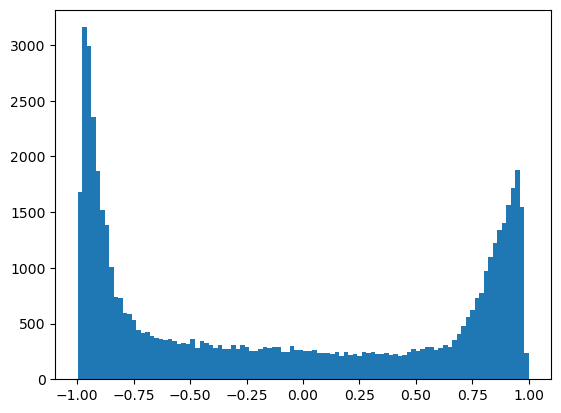

<Figure size 640x480 with 0 Axes>

In [13]:
colors = dataset[:].numpy()
print(colors.shape)
colors = colors[:, 2:, :, :]
colors = np.sum(colors[:, 0, :, :] - colors[:, 1, :, :], axis=(1, 2)) / np.sum(colors, axis=(1, 2, 3))
# colors = np.sum(colors[:, 0, :, :] - colors[:, 1, :, :], axis=(1, 2))
# colors = np.sign(colors) * np.log(np.abs(colors) + 1e-8)
print(colors.min(), colors.max())

plt.clf()
plt.hist(colors, bins=100)
plt.show()
plt.clf()

np.save(colors_file, colors)

In [14]:
def PCA_plot(predictions, message="", sample=None):
    # select random elements and do PCA
    if sample is None:
        sample = len(predictions)
    indices = np.random.choice(len(predictions), sample)
    embeddings_slice = predictions[indices, :].numpy()
    num_components = embeddings_slice.shape[1]
    print(f"Using {num_components} components for PCA")
    pca = PCA(n_components=num_components)
    pca.fit(embeddings_slice)
    # print(pca.explained_variance_ratio_[:10])
    # print(pca.singular_values_)
    # print(pca.components_.shape)
    # print the number of components needed to have 95% of the variance
    print(f"Number of components needed to have 95% of the variance: {1+np.argmax(np.cumsum(pca.explained_variance_ratio_) > 0.95)}")

    # plot the first 2 components
    plt.clf()
    plt.title(f"PCA of FUCCI {args.channels} embeddings {message}")
    plt.scatter(pca.components_[0], pca.components_[1])
    plt.show()

    plt.clf()
    fig, ax = plt.subplots()
    plt.title(f"Bar chart of FUCCI {args.channels} PCA components CDF {message}")
    plt.bar(range(len(pca.explained_variance_ratio_)), np.cumsum(pca.explained_variance_ratio_))
    ax.axhline(y=0.95, color='r')
    plt.show()
    return pca

Using 512 components for PCA
Number of components needed to have 95% of the variance: 147


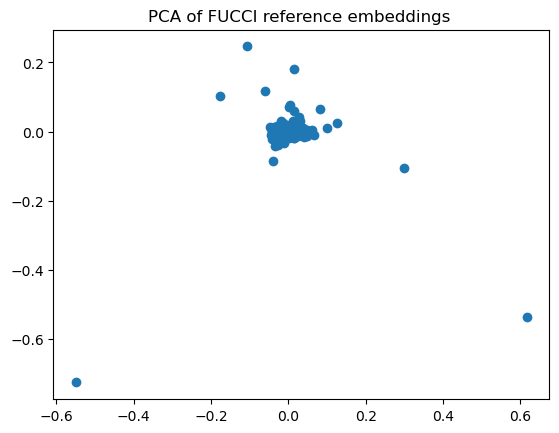

<Figure size 640x480 with 0 Axes>

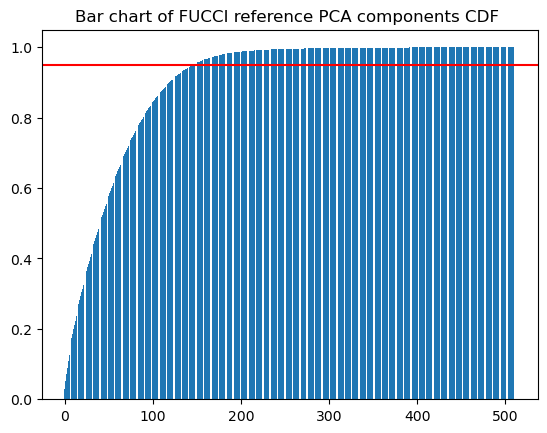

In [15]:
input_entity = mu
pca = PCA_plot(input_entity, message="")

In [16]:
def PHATE_fit(embeddings, sample=None, message=""):
    if isinstance(embeddings, torch.Tensor):
        embeddings = embeddings.numpy()
    if sample is not None:
        indices = np.random.choice(len(embeddings), sample)
        embeddings = embeddings[indices]
    mp_op = multiscale_phate.Multiscale_PHATE()
    return mp_op.fit_transform(embeddings)

def PHATE_plot(mp_embedding, mp_sizes, mp_clusters, message=""):
    scprep.plot.scatter2d(mp_embedding, s=mp_sizes, c=mp_clusters,
                          fontsize=16, ticks=False,label_prefix="Multiscale PHATE", figsize=(10, 10))

Calculating Multiscale PHATE tree...
  Calculating PCA...
  Calculated PCA in 0.07 seconds.
  Calculating diffusion potential...


/home/ishang/.local/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 529 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


  Calculated diffusion potential in 2.90 seconds.
  Setting epsilon to 0.1344
  Setting merge threshold to 0.001
  Calculating condensation...
  Calculated condensation in 14.92 seconds.
Calculated Multiscale PHATE tree in 17.95 seconds.
Computing gradient...
Identifying salient levels of resolution...
Using SMACOF because SGD returned NaN


/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


<Axes: xlabel='Multiscale PHATE1', ylabel='Multiscale PHATE2'>

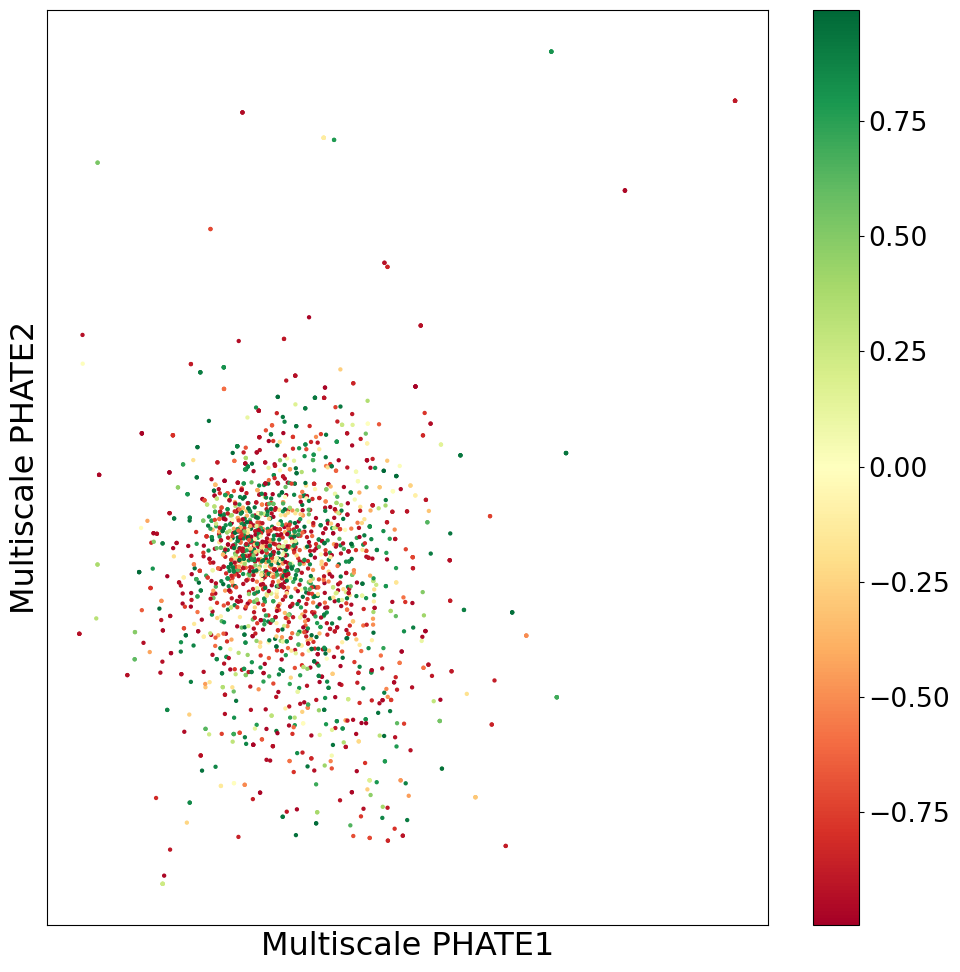

In [17]:
# script to compute PHATE levels, get embeddings separately, and add colors
# can pull this from the github
mp_op = multiscale_phate.Multiscale_PHATE()
indices = np.random.choice(len(predictions), 2000)
embeddings_slice = input_entity[indices, :].numpy()
colors_slice = colors[indices]
levels = mp_op.fit(embeddings_slice)
mp_embedding, mp_clusters, mp_sizes = mp_op.transform(visualization_level = levels[0],
                                                                  cluster_level = levels[0])
scprep.plot.scatter2d(mp_embedding, cmap="RdYlGn", c=colors_slice, fontsize=16, ticks=False, label_prefix="Multiscale PHATE", figsize=(10,10))

Calculating Multiscale PHATE tree...
  Calculating PCA...
  Calculated PCA in 0.07 seconds.
  Calculating diffusion potential...


/home/ishang/.local/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 15 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


  Calculated diffusion potential in 0.82 seconds.
  Setting epsilon to 0.0775
  Setting merge threshold to 0.001
  Calculating condensation...
  Calculated condensation in 8.94 seconds.
Calculated Multiscale PHATE tree in 9.86 seconds.
Computing gradient...
Identifying salient levels of resolution...


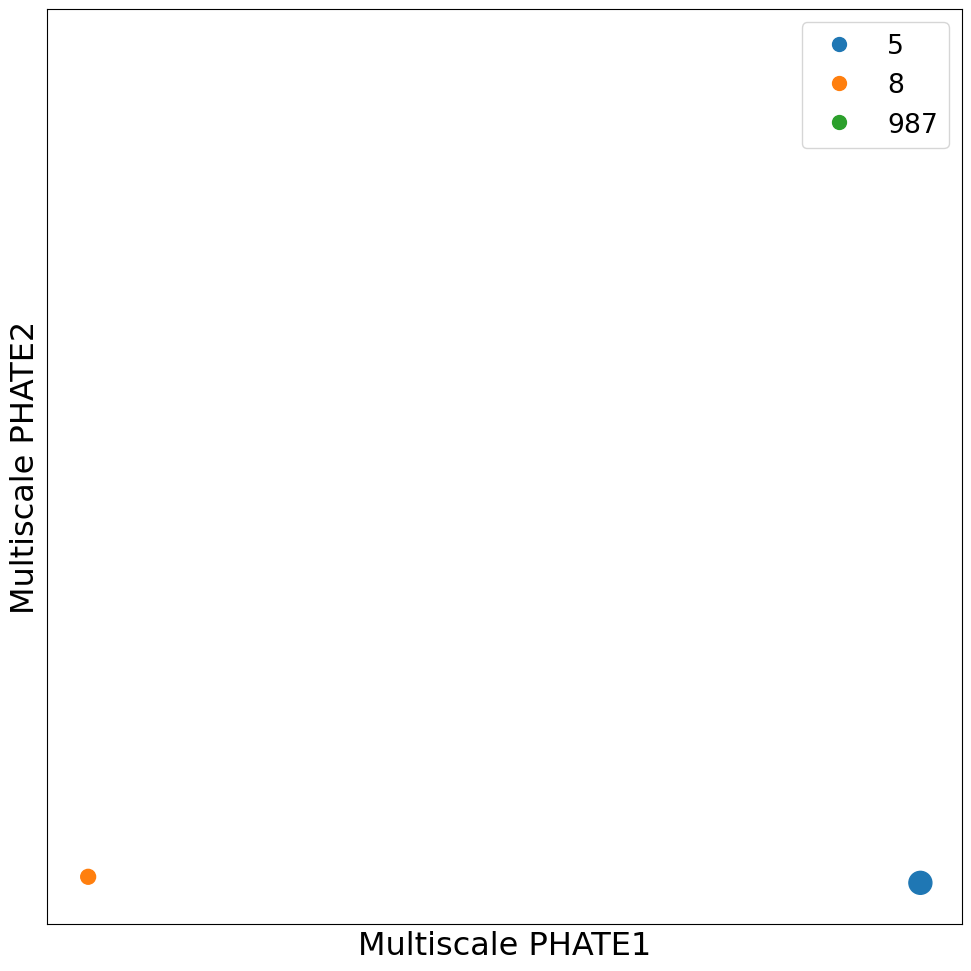

In [18]:
phate_output = PHATE_fit(input_entity, sample=1000)
PHATE_plot(*phate_output, message="")

/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packag

<Axes: >

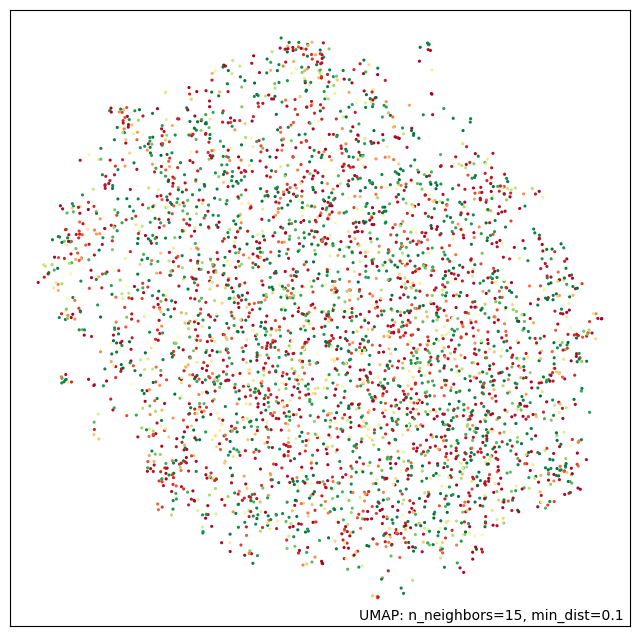

In [19]:
# plot UMAP

import umap
import umap.plot

indices = np.random.choice(len(input_entity), 4000)
embeddings_slice = input_entity[indices, :].numpy()
colors_slice = colors[indices]
umap_embedding = umap.UMAP().fit(embeddings_slice)
# umap.plot.points(umap_embedding)

# plot gradient of red to green for small to large
umap.plot.points(umap_embedding, values=colors_slice, cmap="RdYlGn")

(512, 512)
(4000, 512)
(512, 4000)


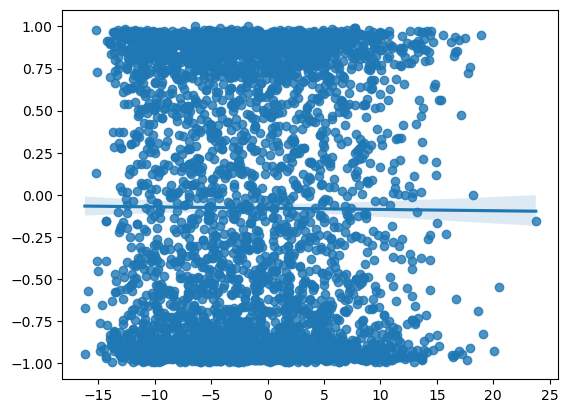

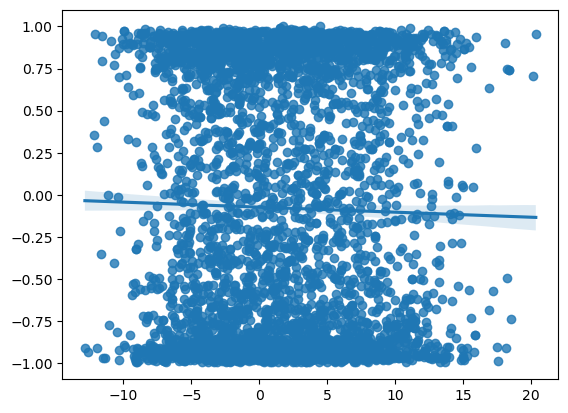

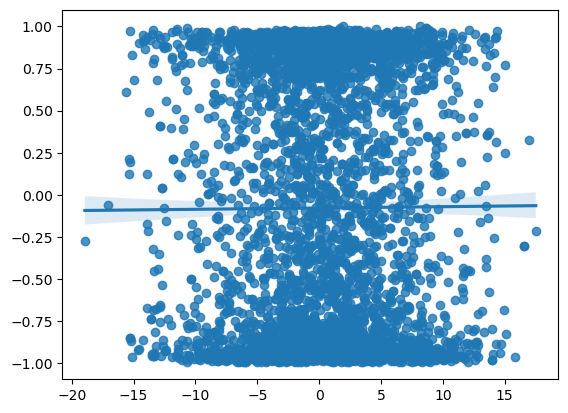

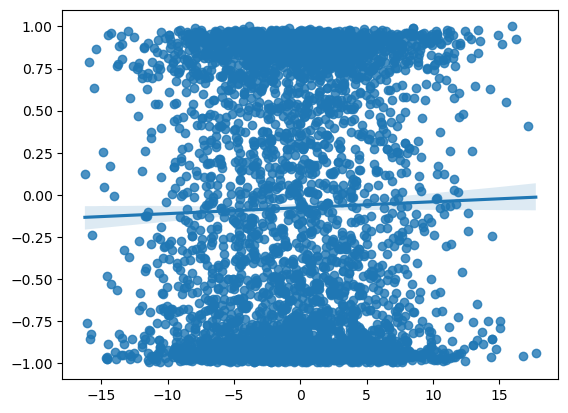

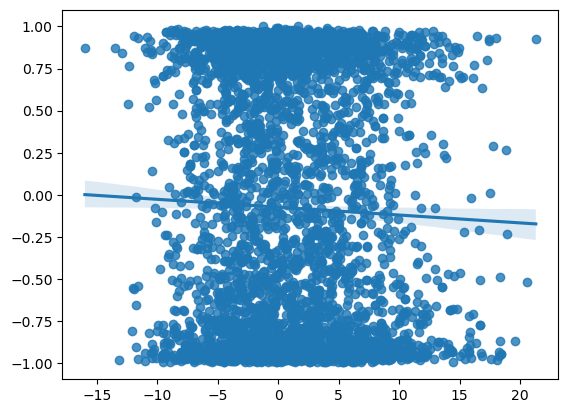

In [20]:
print(pca.components_.shape)
print(embeddings_slice.shape)
pc_embeddings = np.matmul(pca.components_, embeddings_slice.T)
print(pc_embeddings.shape)

num_points = 100
for i in range(5):
    plt.clf()
    fig = sns.regplot(x=pc_embeddings[i], y=colors_slice)
    plt.show()

(4000, 512)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


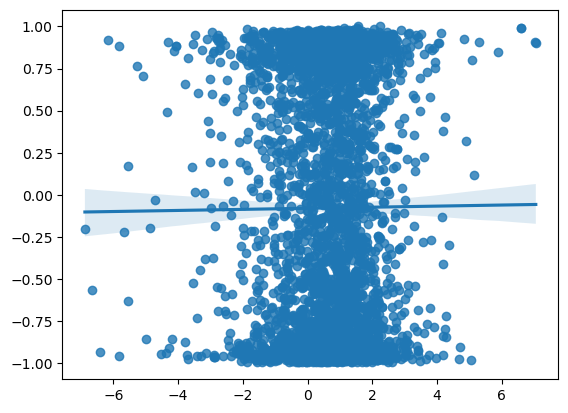

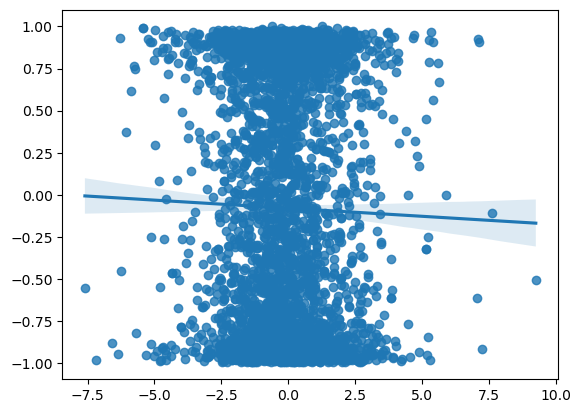

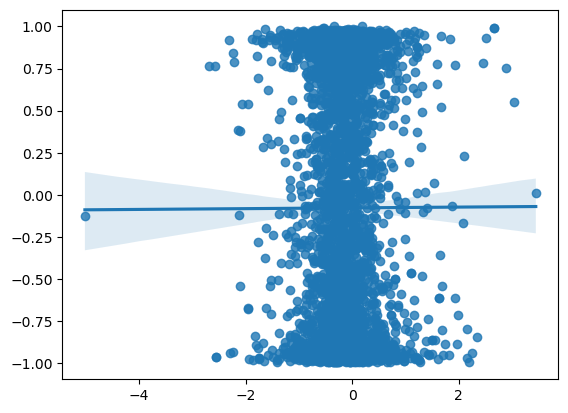

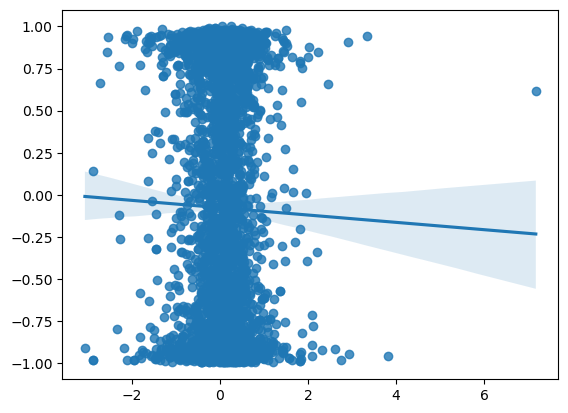

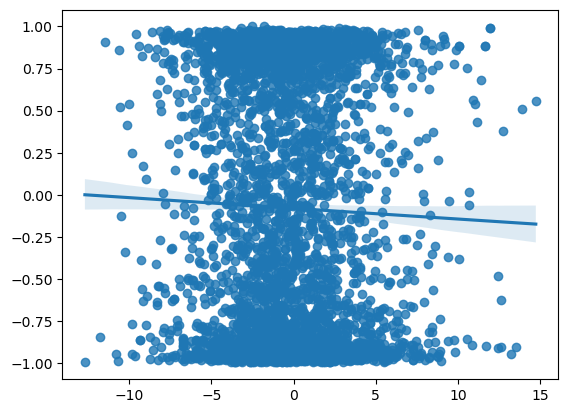

In [21]:
# Plot each variable in the embedding vector against the color and give the R^2 value of the correlation
import seaborn as sns

print(embeddings_slice.shape)
print(type(embeddings_slice), type(colors_slice))
num_points = 100
for i in range(5):
    plt.clf()
    fig = sns.regplot(x=embeddings_slice[:, i],
                y=colors_slice)
    plt.show()

In [22]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(pc_embeddings.T[:800, :10], colors_slice[:800])
print(reg.score(pc_embeddings.T[800:, :10], colors_slice[800:]))
print(reg.coef_)

-0.0039725284055589505
[ 1.8998469e-05 -6.1930781e-03 -1.7703983e-03  3.9915685e-03
 -3.7179159e-03 -1.1241803e-03 -3.7122821e-03 -9.3256368e-04
 -3.8648397e-04 -8.1524476e-03]


In [23]:
# train logistic regression classifier on binarized colors
from sklearn.linear_model import LogisticRegression
reg = LogisticRegression(max_iter=1000)
reg.fit(pc_embeddings.T[:800, :10], colors_slice[:800] > 0)
print(reg.score(pc_embeddings.T[800:, :10], colors_slice[800:] > 0))

0.5453125
